In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import os
import glob
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, plot_roc_curve
import statsmodels.api as sm
# pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
# !pip install graphviz
# !pip install pydotplus
# conda install graphviz
from six import StringIO
from sklearn import metrics

# # Data Preparation

### 1. Data Creation

#### # Creating empty main csv file with all features name

In [2]:
df_main1 = pd.DataFrame(columns = ['name' ,'activity' ,'weight', 'duration','start_time' ,'change_in_load', 'variance',  'maximum', 'median', 'skewness', 'kurtosis', '0.9_quantile', 'acceleration', 'jerk', 'velocity', 'energy', 'power', 'momentum'])
df_main1

,name,activity,weight,duration,start_time,change_in_load,variance,maximum,median,skewness,kurtosis,0.9_quantile,acceleration,jerk,velocity,energy,power,momentum


#### # Creating a function of value incertion in main csv file

In [3]:
def value_insertion(loc_csv):
    df=pd.read_csv(loc_csv)
#     print(loc_csv) # Print this if you want to track which folder is running while running the code
    df_main1.loc[len(df_main1.index)] = [df['name'][0], df['activity'][0], df['weight'][0], df['timestamp'][len(df)-1], df['start_time'][0], df['diff_load_sum'].mean(), df['diff_load_sum'].var(), df['diff_load_sum'].max(), df['diff_load_sum'].median(), df['diff_load_sum'].skew(), df['diff_load_sum'].kurtosis(), df['diff_load_sum'].quantile(0.9), df['acc'].mean(), df['jerk'].mean(), df['velo'].mean(), df['enr'].mean(), df['power'].mean(), df['mom'].mean()]
    return df_main1

#### # Creating a list with all folder's name

In [4]:
rootdir = "D:/Ajit/pip/sample_labeled9"
folder_list = []
for subdir, dirs, files in os.walk(rootdir):
    folder_list.append(subdir)
del folder_list[0]

#### # Value insertion in main csv file

In [5]:
i=0
for folder in folder_list:
    path=folder
    for filename in os.listdir(path):
        x=path+'/'+filename
#         print(i)  # Print this if you want to track which folder is running while running the code
        value_insertion(x)
        i+=1

In [52]:
# Taking backup of loaded dataset as 'df_main1'
df_main=df_main1.copy()

In [53]:
df_main.describe()

,weight,duration,change_in_load,variance,maximum,median,skewness,kurtosis,0.9_quantile,acceleration,jerk,velocity,energy,power,momentum
count,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,1.307500e+04,13065.000000,1.307500e+04,13075.000000,1.307500e+04,13075.000000
mean,4808.845889,112.914337,0.560755,0.972152,11.925079,0.237188,4.949373,41.488459,1.378635,inf,2.142080,inf,410.516441,inf,40.152729
std,999.232091,58.472873,0.315444,1.789492,5.586502,0.277260,1.730340,26.271077,0.706296,NaN,7.372236,NaN,4198.300503,NaN,32.591943
min,0.000000,3.983949,0.012697,0.000094,0.049050,0.009810,0.266555,-0.320153,0.019620,2.507365e-03,0.049039,1.033934e-01,0.000000,2.055424e-03,0.000000
25%,4177.000000,74.374931,0.336593,0.406370,8.343405,0.058860,3.553850,19.765922,0.922140,7.158230e-02,1.195689,3.806761e+00,40.620365,1.030029e+00,17.607188
50%,4651.000000,105.928439,0.494657,0.683053,11.016826,0.127530,4.699613,36.995586,1.330236,1.042276e-01,1.763112,6.625584e+00,126.492901,2.428485e+00,30.910293
75%,5500.000000,140.805793,0.710324,1.111458,14.314458,0.304110,6.117379,57.969277,1.765800,1.517832e-01,2.511230,1.109004e+01,373.057590,5.830805e+00,53.728786
max,21875.000000,669.461843,3.217967,142.648742,116.778240,1.353780,13.054955,222.738669,6.984720,inf,633.883305,inf,408548.227175,inf,669.000505


In [54]:
df_main.columns

Index(['name', 'activity', 'weight', 'duration', 'start_time',
       'change_in_load', 'variance', 'maximum', 'median', 'skewness',
       'kurtosis', '0.9_quantile', 'acceleration', 'jerk', 'velocity',
       'energy', 'power', 'momentum'],
      dtype='object')

### 2. Data cleaning and Outlier removal

In [55]:
# Replacing NaN Name as 'unknown' (246 Rows)
df_main['name'].fillna('unknown',inplace=True)

# Dropping NaN Rows (13 Rows)
df_main.dropna(inplace=True)

# Dropping rows with weight less than 1kg (27 Rows) and more than 8kg (8 Rows).
df_main=df_main[(df_main['weight']>1000) & (df_main['weight']<8000)]

# Activity "duration" (15 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['duration']>450))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['duration']>360))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['duration']>400))]

# "Change in load" (20 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['change_in_load']>1.8))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['change_in_load']>1.8))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['change_in_load']>1.5))]

# 'Variance' (17 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['variance']>8))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['variance']>15))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['variance']>7))]

# 'Skewness' (4 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['skewness']>10))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['skewness']>11))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['skewness']>12))]

# 'Acceleration' (20 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['acceleration']>0.41))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['acceleration']>0.34))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['acceleration']>0.34))]

# 'Jerk' (22 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['jerk']>7))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['jerk']>6))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['jerk']>5.8))]

# 'Velocity' (23 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['velocity']>45))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['velocity']>32))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['velocity']>34))]

# 'Energy' (34 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['energy']>5000))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['energy']>2100))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['energy']>3000))]

# 'Power' (34 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['power']>47))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['power']>20))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['power']>27))]

# 'Momentum' (21 Rows)
df_main=df_main[~((df_main['activity']=='defecation') & (df_main['momentum']>195))]
df_main=df_main[~((df_main['activity']=='non_elimination') & (df_main['momentum']>125))]
df_main=df_main[~((df_main['activity']=='urination') & (df_main['momentum']>135))]

df_main=df_main[~((df_main['activity']=='defecation') & (df_main['energy']>4500))]

df_main.shape

(12817, 18)

### 3. Final Data

In [56]:
# Converting 'urination' and 'defecation' to 'elimination'
elemination_condition = ['urination', 'defecation']
df_main['activity1']=df_main['activity'].apply(lambda x: x if x not in elemination_condition else 'elemination')

# Onehot encoding
df_main=pd.get_dummies(df_main, columns=['activity1'])

# Droping non numeric columns
df_main.drop(['name','activity', 'start_time', 'activity1_non_elimination'],axis=1,inplace=True)

df_main.head()

,weight,duration,change_in_load,variance,maximum,median,skewness,kurtosis,0.9_quantile,acceleration,jerk,velocity,energy,power,momentum,activity1_elemination
0,6933,163.975000,1.114670,2.425972,14.11659,0.43164,2.088879,5.125106,3.23730,0.160777,2.623752,18.629980,1422.404601,14.699895,129.161654,1
1,6451,204.774940,0.996088,2.262248,19.98297,0.32373,2.502551,9.150935,3.06072,0.154408,2.854197,20.030623,1626.238512,15.753942,129.217548,1
2,7240,59.975000,0.292591,0.218968,4.16925,0.05886,2.892435,11.742110,0.87309,0.040413,0.638543,1.792097,13.463229,0.355113,12.974780,1
3,7124,156.775000,0.952895,2.215583,12.43908,0.23544,2.385345,6.859419,2.95281,0.133758,2.379447,14.293334,898.360000,9.996573,101.825709,1
4,7150,183.974939,1.174555,3.997131,15.75486,0.14715,2.486553,7.492540,3.96324,0.164273,2.929181,21.458935,2029.562636,17.758225,153.431382,1


### 4. Upsampling

In [57]:
df_majority = df_main[df_main.activity1_elemination==1]
df_minority = df_main[df_main.activity1_elemination==0]

df_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=0)

df_main = pd.concat([df_majority, df_upsampled])

# # Feature selection using Backward Elimination

### step 1: Data splitting to train, test and validation

In [58]:
df_shuffeled=df_main.sample(frac=1,random_state=101)

df_train=df_shuffeled[:int(len(df_shuffeled)*0.6)]
df_validate=df_shuffeled[int(len(df_shuffeled)*.6):int(len(df_shuffeled)*0.8)]
df_test=df_shuffeled[int(len(df_shuffeled)*0.8):]


x_train = df_train.drop(columns='activity1_elemination')
y_train = df_train['activity1_elemination']

x_validate = df_validate.drop(columns='activity1_elemination')
y_validate = df_validate['activity1_elemination']

x_test = df_test.drop(columns='activity1_elemination')
y_test = df_test['activity1_elemination']

### step 2: Performance of Training, Validation and Test set using Logistic Regression 

In [59]:
def error_metrics(actual, predicted, x_data):
    print('Accuracy %age: ' + str(np.round(accuracy_score(actual, predicted)*100,2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, log_reg.predict_proba(x_data)[:,1]),2)))
    print('\nClassification Report: ')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix: ')
    print(confusion_matrix(actual, predicted))
    return 'Done'

In [60]:
# Training the model using Logistic Regression
log_reg = LogisticRegression(random_state=10)
log_reg.fit(x_train, y_train)

# Performance of Training Set
print('\nTraining\n--------------------------')
y_train_pred=log_reg.predict(x_train)
error_metrics(y_train, y_train_pred, x_train)

# Performance of Validation Set
print('\nValidation\n--------------------------')
y_validate_pred=log_reg.predict(x_validate)
error_metrics(y_validate, y_validate_pred, x_validate)

# Performance of Test set
print('\nTesting\n--------------------------')
y_test_pred=log_reg.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)


Training
--------------------------
Accuracy %age: 75.97
ROC-AUC Score: 0.83

Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5267
           1       0.77      0.74      0.76      5275

    accuracy                           0.76     10542
   macro avg       0.76      0.76      0.76     10542
weighted avg       0.76      0.76      0.76     10542


Confusion Matrix: 
[[4101 1166]
 [1367 3908]]

Validation
--------------------------
Accuracy %age: 75.81
ROC-AUC Score: 0.83

Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      1745
           1       0.77      0.74      0.76      1769

    accuracy                           0.76      3514
   macro avg       0.76      0.76      0.76      3514
weighted avg       0.76      0.76      0.76      3514


Confusion Matrix: 
[[1351  394]
 [ 456 1313]]

Testing
--------------------------
Accuracy

C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'Done'

### Step 3: Features coefficient and P-Value evaluation and dropping feature with maximum p val if p-val > 0.05

In [61]:
logit=sm.Logit(y_test, sm.add_constant(x_test)).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     activity1_elemination   No. Observations:                 3514
Model:                             Logit   Df Residuals:                     3498
Method:                              MLE   Df Model:                           15
Date:                   Wed, 14 Dec 2022   Pseudo R-squ.:                     inf
Time:                           21:24:51   Log-Likelihood:                   -inf
converged:                          True   LL-Null:                        0.0000
Covariance Type:               nonrobust   LLR p-value:                     1.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4187      0.867     -0.483      0.629      -2.118       1.281
weight            -0.0003   9.68e-05     -2.902      0.004      -0.000   -9.12e-05
duration           0.0094      0.002      4.252      0.000       0.005       0.014
change_in_load     3.1399      2.149      1.461      0.144      -1.071       7.351
variance          -2.0135      0.243     -8.289      0.000      -2.490      -1.537
maximum            0.1526      0.023      6.566      0.000       0.107       0.198
median            -6.4205      1.129     -5.688      0.000      -8.633      -4.208
skewness          -0.4541      0.204     -2.225      0.026      -0.854      -0.054
kurtosis           0.0214      0.012      1.746      0.081      -0.003       0.045
0.9_quantile       0.5800      0.495      1.171      0.242      -0.391       1.551
acceleration       8.4527      6.585      1.284      0.199      -4.453      21.358
jerk              -0.5405      0.188     -2.877      0.004      -0.909      -0.172
velocity          -0.1282      0.057     -2.268      0.023      -0.239      -0.017
energy            -0.0037      0.000     -9.973      0.000      -0.004      -0.003
power              0.3547      0.051      6.900      0.000       0.254       0.456
momentum           0.0511      0.013      4.033      0.000       0.026       0.076
==================================================================================
"""

#### Droping the feature with maximum p-value  (0.9_quantile)

In [62]:
x_test.drop(['0.9_quantile'],axis=1,inplace=True)

#### Again Calculating P-value of all features

In [64]:
logit=sm.Logit(y_test, sm.add_constant(x_test)).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     activity1_elemination   No. Observations:                 3514
Model:                             Logit   Df Residuals:                     3499
Method:                              MLE   Df Model:                           14
Date:                   Wed, 14 Dec 2022   Pseudo R-squ.:                     inf
Time:                           21:25:29   Log-Likelihood:                   -inf
converged:                          True   LL-Null:                        0.0000
Covariance Type:               nonrobust   LLR p-value:                     1.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0414      0.803     -0.052      0.959      -1.615       1.532
weight            -0.0003   9.66e-05     -2.927      0.003      -0.000   -9.34e-05
duration           0.0093      0.002      4.202      0.000       0.005       0.014
change_in_load     4.8611      1.560      3.116      0.002       1.804       7.918
variance          -1.9927      0.239     -8.335      0.000      -2.461      -1.524
maximum            0.1510      0.023      6.505      0.000       0.105       0.196
median            -7.3085      0.839     -8.712      0.000      -8.953      -5.664
skewness          -0.5560      0.185     -3.012      0.003      -0.918      -0.194
kurtosis           0.0262      0.012      2.254      0.024       0.003       0.049
acceleration       6.7645      6.339      1.067      0.286      -5.659      19.188
jerk              -0.4463      0.168     -2.661      0.008      -0.775      -0.118
velocity          -0.1335      0.056     -2.373      0.018      -0.244      -0.023
energy            -0.0037      0.000    -10.000      0.000      -0.004      -0.003
power              0.3574      0.051      6.956      0.000       0.257       0.458
momentum           0.0524      0.013      4.154      0.000       0.028       0.077
==================================================================================
"""

#### Droping the feature with maximum p-value  (acceleration) 

In [65]:
x_test.drop(['acceleration'],axis=1,inplace=True)

#### Again Calculating P-value of all features

In [66]:
logit=sm.Logit(y_test, sm.add_constant(x_test)).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     activity1_elemination   No. Observations:                 3514
Model:                             Logit   Df Residuals:                     3500
Method:                              MLE   Df Model:                           13
Date:                   Wed, 14 Dec 2022   Pseudo R-squ.:                     inf
Time:                           21:25:40   Log-Likelihood:                   -inf
converged:                          True   LL-Null:                        0.0000
Covariance Type:               nonrobust   LLR p-value:                     1.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1228      0.790      0.155      0.876      -1.426       1.671
weight            -0.0003   8.33e-05     -4.026      0.000      -0.000      -0.000
duration           0.0090      0.002      4.103      0.000       0.005       0.013
change_in_load     6.0897      1.065      5.718      0.000       4.002       8.177
variance          -2.0555      0.234     -8.785      0.000      -2.514      -1.597
maximum            0.1502      0.023      6.488      0.000       0.105       0.196
median            -7.3920      0.839     -8.812      0.000      -9.036      -5.748
skewness          -0.5326      0.183     -2.908      0.004      -0.892      -0.174
kurtosis           0.0254      0.012      2.197      0.028       0.003       0.048
jerk              -0.3507      0.140     -2.503      0.012      -0.625      -0.076
velocity          -0.1037      0.049     -2.128      0.033      -0.199      -0.008
energy            -0.0038      0.000    -10.190      0.000      -0.005      -0.003
power              0.3622      0.051      7.048      0.000       0.261       0.463
momentum           0.0470      0.012      4.081      0.000       0.024       0.070
==================================================================================
"""

In [67]:
x_test.columns

Index(['weight', 'duration', 'change_in_load', 'variance', 'maximum', 'median',
       'skewness', 'kurtosis', 'jerk', 'velocity', 'energy', 'power',
       'momentum'],
      dtype='object')

#### Now all the features has p-val < 0.05

#### Final features are : 1. 'weight', 2. 'duration', 3. 'change_in_load', 4. 'variance', 5. 'maximum', 6. 'median', 7. 'skewness', 8. 'kurtosis', 9. 'jerk', 10. 'velocity', 11. 'energy', 12.  'power', 13. 'momentum'

# # Modelling

### # Final data

In [68]:
df_main.columns

Index(['weight', 'duration', 'change_in_load', 'variance', 'maximum', 'median',
       'skewness', 'kurtosis', '0.9_quantile', 'acceleration', 'jerk',
       'velocity', 'energy', 'power', 'momentum', 'activity1_elemination'],
      dtype='object')

In [69]:
df_main_final=df_main.copy()

In [70]:
# Removed by backward elimination method
df_main_final.drop(['0.9_quantile','acceleration'],axis=1,inplace=True)

# Dropping 'Weight' column as there are no variation shown across activities in boxplot of final EDA
df_main_final.drop(['weight'],axis=1,inplace=True)

In [71]:
# Splitting the data into train, validation and test set

df_shuffeled=df_main_final.sample(frac=1,random_state=101)

df_train=df_shuffeled[:int(len(df_shuffeled)*0.6)]
df_validate=df_shuffeled[int(len(df_shuffeled)*.6):int(len(df_shuffeled)*0.8)]
df_test=df_shuffeled[int(len(df_shuffeled)*0.8):]


x_train = df_train.drop(columns='activity1_elemination')
y_train = df_train['activity1_elemination']

x_validate = df_validate.drop(columns='activity1_elemination')
y_validate = df_validate['activity1_elemination']

x_test = df_test.drop(columns='activity1_elemination')
y_test = df_test['activity1_elemination']

### 1. Modelling with Logistic Regression:

#### i. Training Data

In [72]:
def error_metrics(actual, predicted, x_data):
    print('Accuracy %age: ' + str(np.round(accuracy_score(actual, predicted)*100,2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, log_reg.predict_proba(x_data)[:,1]),2)))
    print('\nClassification Report: ')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix: ')
    print(confusion_matrix(actual, predicted))
    return 'Done'


Training
--------------------------
Accuracy %age: 75.66
ROC-AUC Score: 0.83

Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5267
           1       0.77      0.74      0.75      5275

    accuracy                           0.76     10542
   macro avg       0.76      0.76      0.76     10542
weighted avg       0.76      0.76      0.76     10542


Confusion Matrix: 
[[4093 1174]
 [1392 3883]]

 ROC-AUC Curve for training set


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


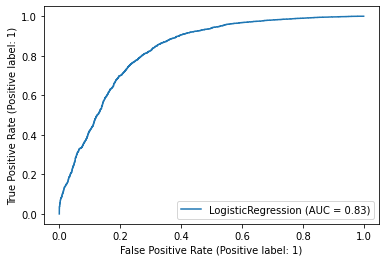

In [73]:
# Training the model with Logistic Regression:
log_reg = LogisticRegression(random_state=10)
log_reg.fit(x_train, y_train)

print('\nTraining\n--------------------------')
y_train_pred=log_reg.predict(x_train)
error_metrics(y_train, y_train_pred, x_train)
print('\n ROC-AUC Curve for training set')
plot_roc_curve(log_reg, x_train, y_train)
plt.show()

#### ii. Validation Data


Validation
--------------------------
Accuracy %age: 76.18
ROC-AUC Score: 0.83

Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      1745
           1       0.77      0.75      0.76      1769

    accuracy                           0.76      3514
   macro avg       0.76      0.76      0.76      3514
weighted avg       0.76      0.76      0.76      3514


Confusion Matrix: 
[[1357  388]
 [ 449 1320]]

 ROC-AUC Curve for validate set


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


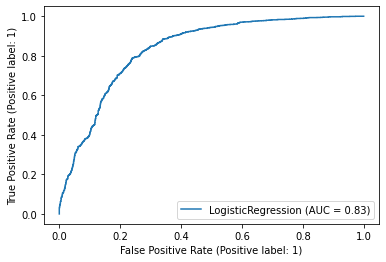

In [74]:
print('\nValidation\n--------------------------')
y_validate_pred=log_reg.predict(x_validate)
error_metrics(y_validate, y_validate_pred, x_validate)
print('\n ROC-AUC Curve for validate set')
plot_roc_curve(log_reg, x_validate, y_validate)
plt.show()

#### iii. Test Data


Testing
--------------------------
Accuracy %age: 74.47
ROC-AUC Score: 0.82

Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1773
           1       0.75      0.73      0.74      1741

    accuracy                           0.74      3514
   macro avg       0.74      0.74      0.74      3514
weighted avg       0.74      0.74      0.74      3514


Confusion Matrix: 
[[1345  428]
 [ 469 1272]]

 ROC-AUC Curve for test set


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


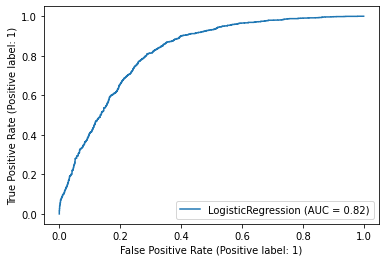

In [75]:
print('\nTesting\n--------------------------')
y_test_pred=log_reg.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)
print('\n ROC-AUC Curve for test set')
plot_roc_curve(log_reg, x_test, y_test)
plt.show()

#### # Threshold = 0.4
#### False negetive has decreased & Recall of positive class has increased


Testing
--------------------------
Accuracy %age: 75.53
ROC-AUC Score: 0.82

Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      1773
           1       0.72      0.84      0.77      1741

    accuracy                           0.76      3514
   macro avg       0.76      0.76      0.75      3514
weighted avg       0.76      0.76      0.75      3514


Confusion Matrix: 
[[1198  575]
 [ 285 1456]]

 ROC-AUC Curve for test set


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


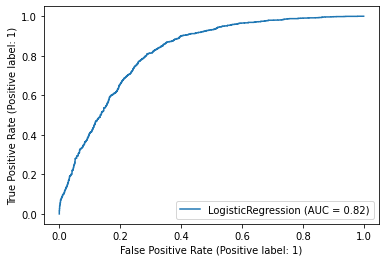

In [76]:
log_reg = LogisticRegression(random_state=10)
log_reg.fit(x_train, y_train)
print('\nTesting\n--------------------------')
y_test_probability = log_reg.predict_proba(x_test)[:,1]
y_test_pred=np.where(y_test_probability >= 0.4, 1, 0)
error_metrics(y_test, y_test_pred, x_test)
print('\n ROC-AUC Curve for test set')
plot_roc_curve(log_reg, x_test, y_test)
plt.show()

#### # Threshold = 0.6
#### False positive has decreased & Recall of negetice class has decreased


Testing
--------------------------
Accuracy %age: 71.46
ROC-AUC Score: 0.82

Classification Report: 
              precision    recall  f1-score   support

           0       0.68      0.82      0.74      1773
           1       0.77      0.61      0.68      1741

    accuracy                           0.71      3514
   macro avg       0.72      0.71      0.71      3514
weighted avg       0.72      0.71      0.71      3514


Confusion Matrix: 
[[1446  327]
 [ 676 1065]]

 ROC-AUC Curve for test set


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


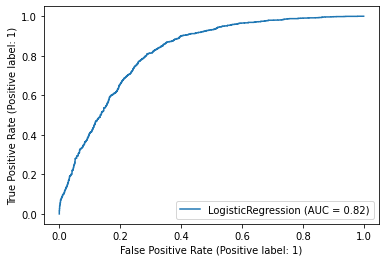

In [77]:
log_reg = LogisticRegression(random_state=10)
log_reg.fit(x_train, y_train)
print('\nTesting\n--------------------------')
y_test_probability = log_reg.predict_proba(x_test)[:,1]
y_test_pred=np.where(y_test_probability >= 0.6, 1, 0)
error_metrics(y_test, y_test_pred, x_test)
print('\n ROC-AUC Curve for test set')
plot_roc_curve(log_reg, x_test, y_test)
plt.show()

### 2. Modelling with XG Boost

In [32]:
def error_metrics(actual, predicted, x_data):
    print('Accuracy %age: ' + str(np.round(accuracy_score(actual, predicted)*100,2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, xgb_grid_search.predict_proba(x_data)[:,1]),2)))
    print('\nClassification Report: ')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix: ')
    print(confusion_matrix(actual, predicted))
    return 'Done'

In [107]:
xgb_weighted = XGBClassifier(verbsity=0, random_state=3)
grid_list={'nthread':[4], 'objective':['binary:logistic'], 'learning_rate':[0.001, 0.01, 0.03], 
           'max_depth':[5,6,7], 'min_child_weight':[3,4], 'silent':[1],
           'subsample':[0.7], 'colsample_bytree':[0.7],'n_estimators':[100]}
xgb_grid_search = GridSearchCV(estimator=xgb_weighted, param_grid=grid_list, cv=10, n_jobs=4, verbose=False, scoring='roc_auc')
xgb_grid_search.fit(x_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_

[13:05:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent", "verbsity" } are not used.



#### i. Train Set


Training
--------------------------
Accuracy %age: 86.61
ROC-AUC Score: 0.94

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      5267
           1       0.82      0.93      0.87      5275

    accuracy                           0.87     10542
   macro avg       0.87      0.87      0.87     10542
weighted avg       0.87      0.87      0.87     10542


Confusion Matrix: 
[[4223 1044]
 [ 368 4907]]

 ROC-AUC Curve for test set


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


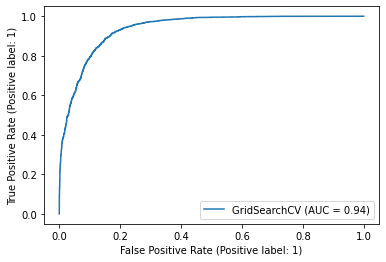

In [108]:
print('\nTraining\n--------------------------')
y_train_pred=xgb_best_model.predict(x_train)
error_metrics(y_train, y_train_pred, x_train)
print('\n ROC-AUC Curve for test set')
plot_roc_curve(xgb_grid_search, x_train, y_train)
plt.show()

#### ii. Validation Set


Validation
--------------------------
Accuracy %age: 83.1
ROC-AUC Score: 0.91

Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1745
           1       0.79      0.90      0.84      1769

    accuracy                           0.83      3514
   macro avg       0.84      0.83      0.83      3514
weighted avg       0.84      0.83      0.83      3514


Confusion Matrix: 
[[1322  423]
 [ 171 1598]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


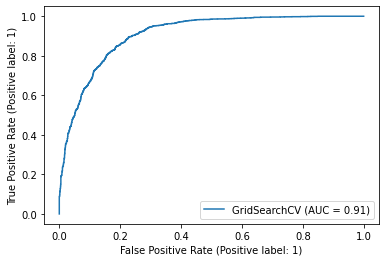

In [109]:
print('\nValidation\n--------------------------')
y_validate_pred=xgb_best_model.predict(x_validate)
error_metrics(y_validate, y_validate_pred, x_validate)
plot_roc_curve(xgb_grid_search, x_validate, y_validate)
plt.show()

#### iii. Test Set


Testing
--------------------------
Accuracy %age: 81.64
ROC-AUC Score: 0.89

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.75      0.80      1773
           1       0.78      0.88      0.83      1741

    accuracy                           0.82      3514
   macro avg       0.82      0.82      0.82      3514
weighted avg       0.82      0.82      0.82      3514


Confusion Matrix: 
[[1330  443]
 [ 202 1539]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


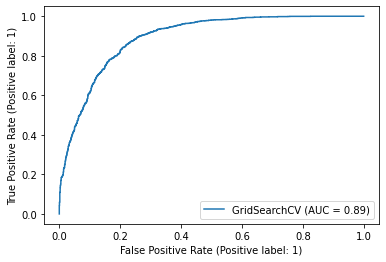

In [110]:
print('\nTesting\n--------------------------')
y_test_pred=xgb_best_model.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)
plot_roc_curve(xgb_grid_search, x_test, y_test)
plt.show()

#### # Feature Importance

In [111]:
xgb_imp_df = pd.DataFrame()
xgb_imp_df['Features'] = x_test.columns
xgb_imp_df['Importance'] = xgb_best_model.feature_importances_
xgb_imp_df = xgb_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
xgb_imp_df

,Features,Importance
0,velocity,0.295971
1,energy,0.251070
2,duration,0.089081
3,median,0.057342
4,change_in_load,0.048192
5,power,0.046702
6,variance,0.039433
7,jerk,0.037312
8,momentum,0.036748
9,skewness,0.035690


<AxesSubplot: xlabel='Importance', ylabel='Features'>

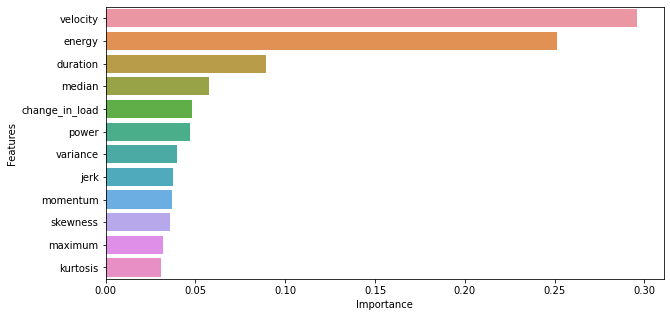

In [113]:
plt.figure(figsize = (10,5))
sns.barplot(x = 'Importance', y = 'Features', data = xgb_imp_df)

### 3. Modelling with SVM

In [32]:
def error_metrics(actual, predicted, x_data):
    print('Accuracy %age: ' + str(np.round(accuracy_score(actual, predicted)*100,2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, classifier.predict_proba(x_data)[:,1]),2)))
    print('\nClassification Report: ')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix: ')
    print(confusion_matrix(actual, predicted))
    return 'Done'

In [45]:
from sklearn.svm import SVC  
classifier = SVC(kernel='linear', probability=True) 
  
# fitting x samples and y classes 
classifier.fit(x_train, y_train)

SVC(kernel='linear', probability=True)

#### i. Train Set


Training
--------------------------
Accuracy %age: 75.79
ROC-AUC Score: 0.83

Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      5267
           1       0.78      0.72      0.75      5275

    accuracy                           0.76     10542
   macro avg       0.76      0.76      0.76     10542
weighted avg       0.76      0.76      0.76     10542


Confusion Matrix: 
[[4209 1058]
 [1494 3781]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


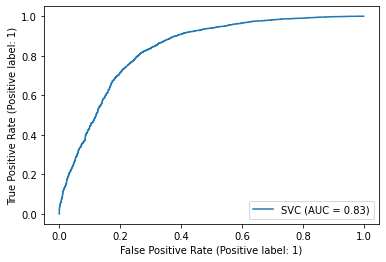

In [46]:
print('\nTraining\n--------------------------')
y_train_pred=classifier.predict(x_train)
error_metrics(y_train, y_train_pred, x_train)
plot_roc_curve(classifier, x_train, y_train)
plt.show()

#### ii. Validation set


Validation
--------------------------
Accuracy %age: 76.55
ROC-AUC Score: 0.84

Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1745
           1       0.79      0.73      0.76      1769

    accuracy                           0.77      3514
   macro avg       0.77      0.77      0.77      3514
weighted avg       0.77      0.77      0.77      3514


Confusion Matrix: 
[[1392  353]
 [ 471 1298]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


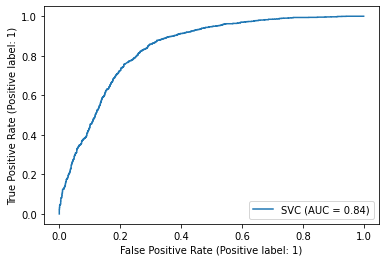

In [47]:
print('\nValidation\n--------------------------')
y_validate_pred=classifier.predict(x_validate)
error_metrics(y_validate, y_validate_pred, x_validate)
plot_roc_curve(classifier, x_validate, y_validate)
plt.show()

#### iii. Test Set


Testing
--------------------------
Accuracy %age: 73.93
ROC-AUC Score: 0.82

Classification Report: 
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1773
           1       0.75      0.71      0.73      1741

    accuracy                           0.74      3514
   macro avg       0.74      0.74      0.74      3514
weighted avg       0.74      0.74      0.74      3514


Confusion Matrix: 
[[1363  410]
 [ 506 1235]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


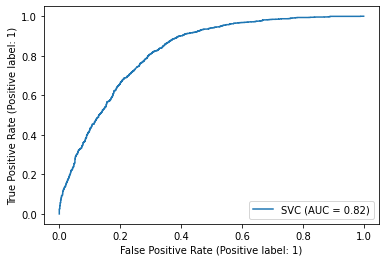

In [48]:
print('\nTesting\n--------------------------')
y_test_pred=classifier.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)
plot_roc_curve(classifier, x_test, y_test)
plt.show()

### 4. Modelling with KNN

In [78]:
def error_metrics(actual, predicted, x_data):
    print('Accuracy %age: ' + str(np.round(accuracy_score(actual, predicted)*100,2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, classifier.predict_proba(x_data)[:,1]),2)))
    print('\nClassification Report: ')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix: ')
    print(confusion_matrix(actual, predicted))
    return 'Done'

In [79]:
from sklearn.neighbors import KNeighborsClassifier  
classifier= KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=2 )  
classifier.fit(x_train, y_train) 

KNeighborsClassifier(n_neighbors=10)

#### i. Train Set


Training
--------------------------
Accuracy %age: 81.49
ROC-AUC Score: 0.91

Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      5267
           1       0.83      0.80      0.81      5275

    accuracy                           0.81     10542
   macro avg       0.82      0.81      0.81     10542
weighted avg       0.82      0.81      0.81     10542


Confusion Matrix: 
[[4396  871]
 [1080 4195]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


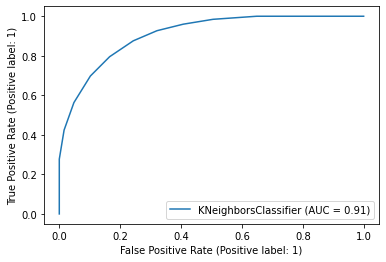

In [80]:
print('\nTraining\n--------------------------')
y_train_pred=classifier.predict(x_train)
error_metrics(y_train, y_train_pred, x_train)
plot_roc_curve(classifier, x_train, y_train)
plt.show()

#### ii. Validation Set


Validation
--------------------------
Accuracy %age: 77.77
ROC-AUC Score: 0.87

Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1745
           1       0.78      0.77      0.78      1769

    accuracy                           0.78      3514
   macro avg       0.78      0.78      0.78      3514
weighted avg       0.78      0.78      0.78      3514


Confusion Matrix: 
[[1371  374]
 [ 407 1362]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


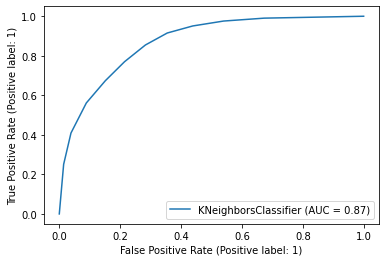

In [82]:
print('\nValidation\n--------------------------')
y_validate_pred=classifier.predict(x_validate)
error_metrics(y_validate, y_validate_pred, x_validate)
plot_roc_curve(classifier, x_validate, y_validate)
plt.show()

#### iii. Test Set


Testing
--------------------------
Accuracy %age: 77.26
ROC-AUC Score: 0.85

Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1773
           1       0.78      0.76      0.77      1741

    accuracy                           0.77      3514
   macro avg       0.77      0.77      0.77      3514
weighted avg       0.77      0.77      0.77      3514


Confusion Matrix: 
[[1392  381]
 [ 418 1323]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


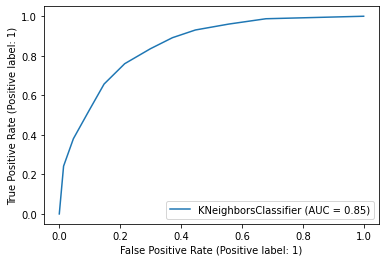

In [84]:
print('\nTesting\n--------------------------')
y_test_pred=classifier.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)
plot_roc_curve(classifier, x_test, y_test)
plt.show()

### 5. Modelling with Decision Tree 

In [85]:
def error_metrics(actual, predicted, x_data):
    print('Accuracy %age: ' + str(np.round(accuracy_score(actual, predicted)*100,2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, classifier.predict_proba(x_data)[:,1]),2)))
    print('\nClassification Report: ')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix: ')
    print(confusion_matrix(actual, predicted))
    return 'Done'

#### i. Training Set


Training
--------------------------
Accuracy %age: 86.41
ROC-AUC Score: 0.94

Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5267
           1       0.83      0.91      0.87      5275

    accuracy                           0.86     10542
   macro avg       0.87      0.86      0.86     10542
weighted avg       0.87      0.86      0.86     10542


Confusion Matrix: 
[[4295  972]
 [ 461 4814]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


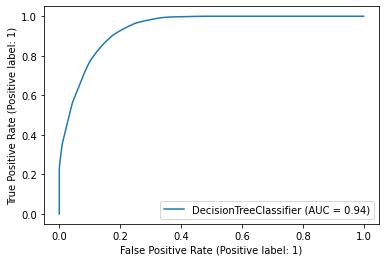

In [90]:
classifier = DecisionTreeClassifier(criterion='entropy', max_depth =10, random_state=10)
classifier.fit(x_train, y_train)

print('\nTraining\n--------------------------')
y_train_pred=classifier.predict(x_train)
error_metrics(y_train, y_train_pred, x_train)
plot_roc_curve(classifier, x_train, y_train)
plt.show()

#### ii. Validation Set


Validation
--------------------------
Accuracy %age: 80.76
ROC-AUC Score: 0.87

Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.76      0.80      1745
           1       0.79      0.85      0.82      1769

    accuracy                           0.81      3514
   macro avg       0.81      0.81      0.81      3514
weighted avg       0.81      0.81      0.81      3514


Confusion Matrix: 
[[1334  411]
 [ 265 1504]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


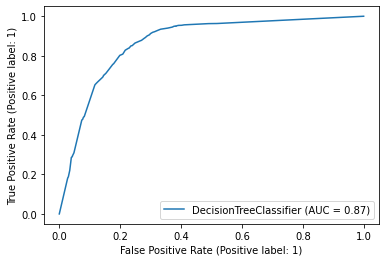

In [91]:
print('\nValidation\n--------------------------')
y_validate_pred=classifier.predict(x_validate)
error_metrics(y_validate, y_validate_pred, x_validate)
plot_roc_curve(classifier, x_validate, y_validate)
plt.show()

#### iii. Test Set


Testing
--------------------------
Accuracy %age: 79.62
ROC-AUC Score: 0.86

Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1773
           1       0.77      0.84      0.80      1741

    accuracy                           0.80      3514
   macro avg       0.80      0.80      0.80      3514
weighted avg       0.80      0.80      0.80      3514


Confusion Matrix: 
[[1329  444]
 [ 272 1469]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


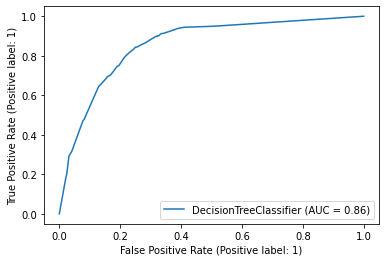

In [92]:
print('\nTesting\n--------------------------')
y_test_pred=classifier.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)
plot_roc_curve(classifier, x_test, y_test)
plt.show()

#### # Feature Importance

In [93]:
dt_df = pd.DataFrame()
dt_df['Features'] = x_test.columns
dt_df['Importance'] = classifier.feature_importances_
dt_df = dt_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
dt_df

,Features,Importance
0,velocity,0.392576
1,duration,0.160983
2,median,0.073315
3,jerk,0.060238
4,energy,0.056145
5,skewness,0.050071
6,change_in_load,0.047901
7,variance,0.047344
8,momentum,0.030201
9,power,0.028594


<AxesSubplot: xlabel='Importance', ylabel='Features'>

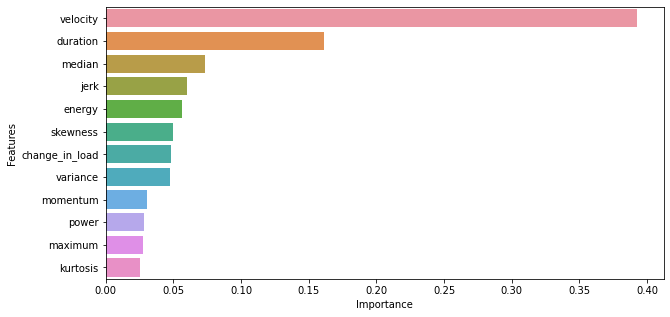

In [94]:
plt.figure(figsize = (10,5))
sns.barplot(x = 'Importance', y = 'Features', data = dt_df)

#### # Visualization of tree

In [95]:
x_train.columns

Index(['duration', 'change_in_load', 'variance', 'maximum', 'median',
       'skewness', 'kurtosis', 'jerk', 'velocity', 'energy', 'power',
       'momentum'],
      dtype='object')

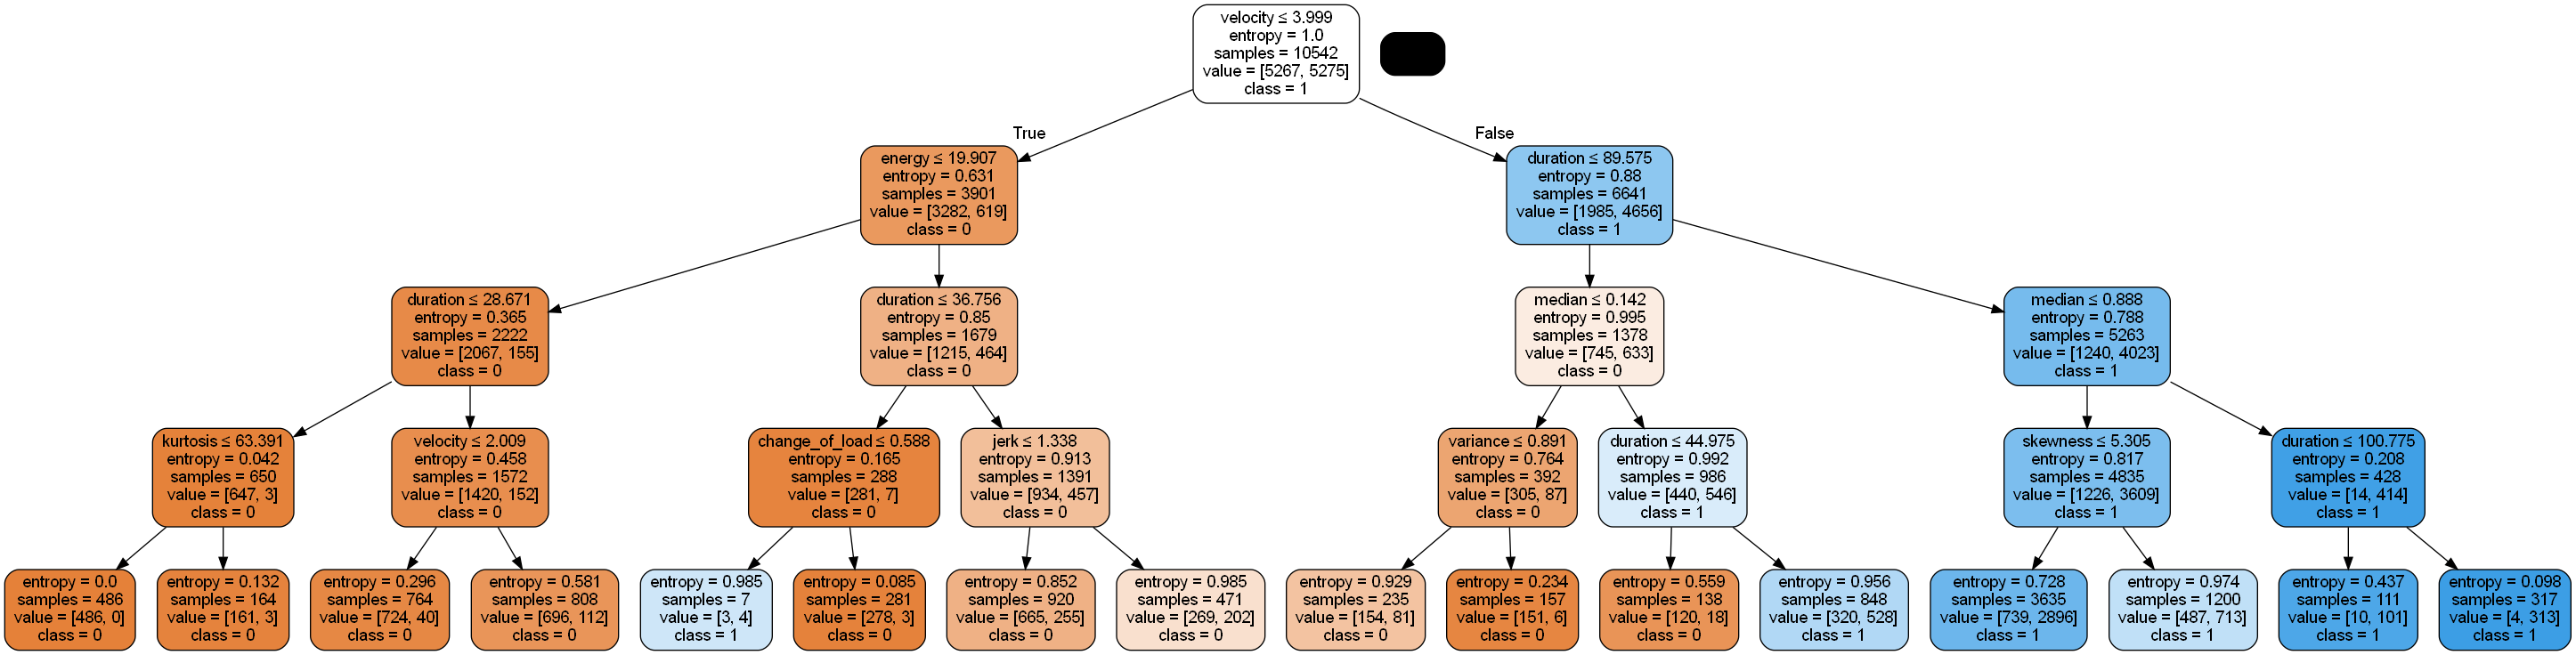

In [96]:
feature_cols=['duration', 'change_of_load', 'variance', 'maximum', 'median',
       'skewness', 'kurtosis', 'jerk', 'velocity', 'energy', 'power',
       'momentum']

# Create Decision Tree classifer object
classifier = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train Decision Tree Classifer
classifier.fit(x_train,y_train)

#Predict the response for test dataset
y_pred = classifier.predict(x_test)

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('main.jpg')
Image(graph.create_png())

### 6. Modelling with Random Forest

In [97]:
def error_metrics(actual, predicted, x_data):
    print('Accuracy %age: ' + str(np.round(accuracy_score(actual, predicted)*100,2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, classifier.predict_proba(x_data)[:,1]),2)))
    print('\nClassification Report: ')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix: ')
    print(confusion_matrix(actual, predicted))
    return 'Done'

#### i. Training Set

## ***( As with this hyper parameter I am getting good Valodation and Test result, though Train result is coming 100%, I have used this hyper parameter for best model performance)


Training
--------------------------
Accuracy %age: 99.97
ROC-AUC Score: 1.0

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5267
           1       1.00      1.00      1.00      5275

    accuracy                           1.00     10542
   macro avg       1.00      1.00      1.00     10542
weighted avg       1.00      1.00      1.00     10542


Confusion Matrix: 
[[5265    2]
 [   1 5274]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


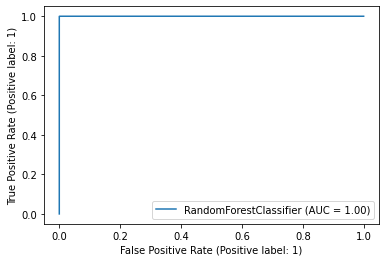

In [111]:
classifier = RandomForestClassifier(n_estimators=55, criterion='entropy',max_depth =35, random_state=10)
classifier.fit(x_train, y_train)

print('\nTraining\n--------------------------')
y_train_pred=classifier.predict(x_train)
error_metrics(y_train, y_train_pred, x_train)
plot_roc_curve(classifier, x_train, y_train)
plt.show()

#### ii. Validation Set


Validation
--------------------------
Accuracy %age: 91.8
ROC-AUC Score: 0.97

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1745
           1       0.92      0.92      0.92      1769

    accuracy                           0.92      3514
   macro avg       0.92      0.92      0.92      3514
weighted avg       0.92      0.92      0.92      3514


Confusion Matrix: 
[[1604  141]
 [ 147 1622]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


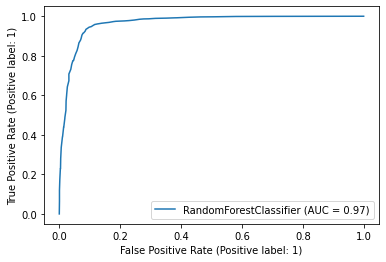

In [112]:
print('\nValidation\n--------------------------')
y_validate_pred=classifier.predict(x_validate)
error_metrics(y_validate, y_validate_pred, x_validate)
plot_roc_curve(classifier, x_validate, y_validate)
plt.show()

#### iii. Test Set


Testing
--------------------------
Accuracy %age: 90.81
ROC-AUC Score: 0.96

Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1773
           1       0.91      0.90      0.91      1741

    accuracy                           0.91      3514
   macro avg       0.91      0.91      0.91      3514
weighted avg       0.91      0.91      0.91      3514


Confusion Matrix: 
[[1618  155]
 [ 168 1573]]


C:\Users\ajit.mishra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


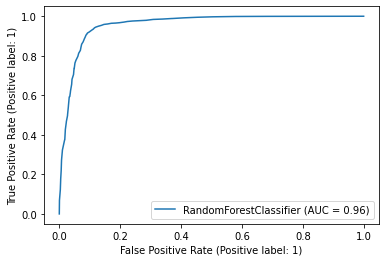

In [113]:
print('\nTesting\n--------------------------')
y_test_pred=classifier.predict(x_test)
error_metrics(y_test, y_test_pred, x_test)
plot_roc_curve(classifier, x_test, y_test)
plt.show()

#### # Feature Importance

In [114]:
x_test.columns

Index(['duration', 'change_in_load', 'variance', 'maximum', 'median',
       'skewness', 'kurtosis', 'jerk', 'velocity', 'energy', 'power',
       'momentum'],
      dtype='object')

In [115]:
RF_df = pd.DataFrame()
RF_df['Features'] = x_test.columns
RF_df['Importance'] = classifier.feature_importances_
RF_df = RF_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
RF_df

,Features,Importance
0,velocity,0.138373
1,duration,0.132932
2,energy,0.114559
3,momentum,0.106842
4,change_in_load,0.075884
5,power,0.070602
6,jerk,0.068148
7,variance,0.063502
8,median,0.060501
9,kurtosis,0.057483


<AxesSubplot: xlabel='Importance', ylabel='Features'>

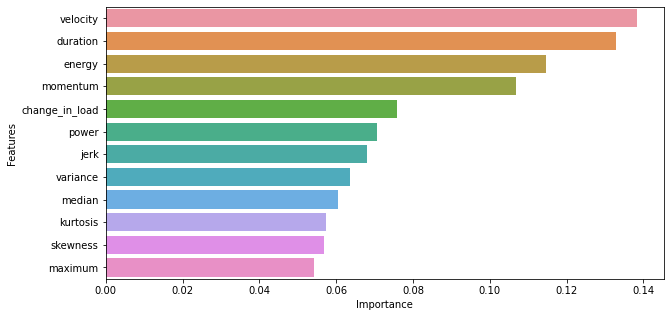

In [116]:
plt.figure(figsize = (10,5))
sns.barplot(x = 'Importance', y = 'Features', data = RF_df)

## PDP Plots

In [57]:
# PDPplot is not installing properly so, I am using seaborn to plot PDP plots

In [58]:
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay)

In [59]:
classifier = RandomForestClassifier(n_estimators=55, criterion='entropy',max_depth =35, random_state=10)
classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=35, n_estimators=55,
                       random_state=10)

#### # Velocity

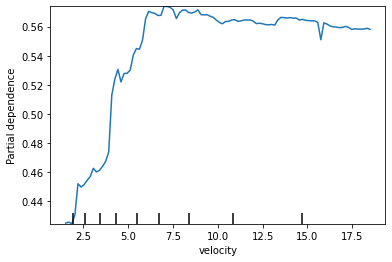

In [152]:
var = 'velocity'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Duration

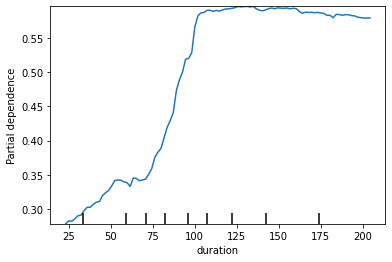

In [60]:
var = 'duration'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Energy

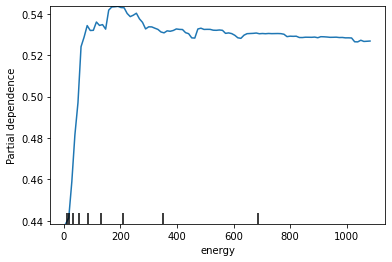

In [151]:
var = 'energy'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Momentum

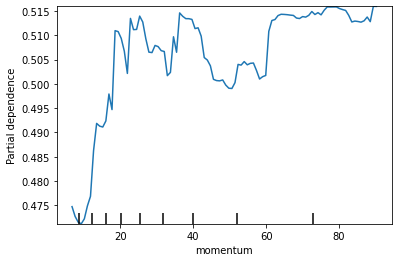

In [153]:
var = 'momentum'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Change in load

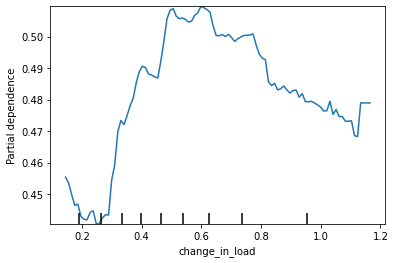

In [150]:
var = 'change_in_load'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Power

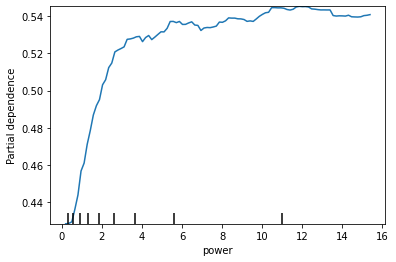

In [62]:
var = 'power'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Jerk

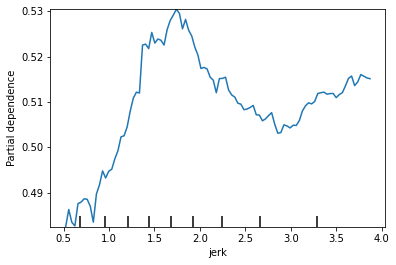

In [61]:
var = 'jerk'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Variance

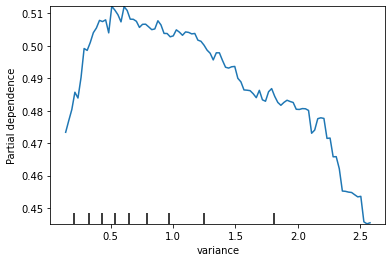

In [64]:
var = 'variance'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Median

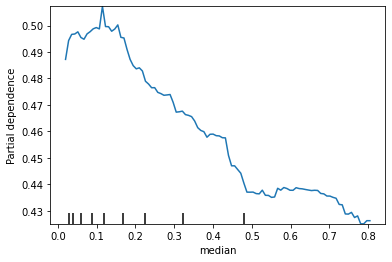

In [65]:
var = 'median'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Skewness

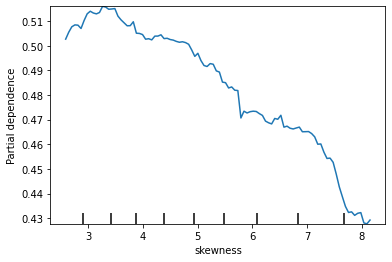

In [66]:
var = 'skewness'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Kurtosis

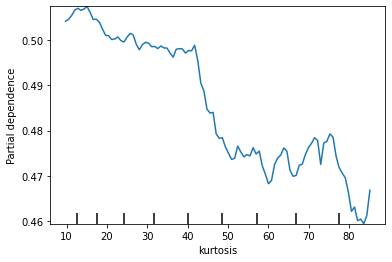

In [67]:
var = 'kurtosis'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

#### # Maximum

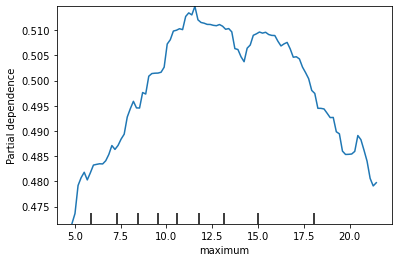

In [68]:
var = 'maximum'
PartialDependenceDisplay.from_estimator(classifier, x_train, [var]);

In [ ]:
# As the dataset has correlated columns so PDP (Partial Dependance Plots) will not show a good result. Alternative method is ALE (Accumulated Local Effects)